In [1]:
import pandas as pd
import numpy as np
import sqlite3

## Database Access and Data Retrieval

In [2]:
conn = sqlite3.connect('../res/data/tables.sql')
cursor = conn.cursor()

In [3]:
# # ['id', 'school', 'gender', 'age', 'home address', 'parents cohabitation', 'moms education', 'dads education', 'moms job', 'dads job', 'choice reason', 'guardian', 'travel time', 'nursery education', 'internet access', 'higher education', 'significant other', 'household size', 'family relationship', 'free time', 'social activities', 'study time', 'first periods grade', 'second periods grade', 'third periods grade','failures', 'absences', 'health', 'weekday drinker', 'weekend drinker', 'drinker']
 
cursor.execute('''
SELECT profile_encoded.id, school, gender, age, "home address", "parents cohabitation", 
"moms education", "dads education", "moms job", "dads job", "choice reason", 
guardian, "travel time", "nursery education", "internet access", "higher education",
"significant other", "household size", "family relationship", "free time",
"social activities", "study time", "first periods grade", "second periods grade",
"third periods grade", failures, absences, health, "weekday drinking",
"weekend drinking", "heavy drinking"
FROM profile_encoded
JOIN activities_encoded
ON profile_encoded.id = activities_encoded.id
''')

rows = cursor.fetchall()
description = cursor.description
conn.close()

In [4]:
# description is a tuple of tuples and we only need the first item in each tuple
# lambda x: x[0] returns the first item of any list, tuple or iterable
description[:3]

(('id', None, None, None, None, None, None),
 ('school', None, None, None, None, None, None),
 ('gender', None, None, None, None, None, None))

In [5]:
df = pd.DataFrame(data=rows, columns=map(lambda x: x[0], description))
df = df.set_index('id')
df[:5]

,school,gender,age,home address,parents cohabitation,moms education,dads education,moms job,dads job,choice reason,...,study time,first periods grade,second periods grade,third periods grade,failures,absences,health,weekday drinking,weekend drinking,heavy drinking
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,18,1,0,4,4,0,2,0,...,2,0,0,0,0,6,3,1,1,0
2,0,1,17,1,1,1,1,0,4,0,...,2,0,0,0,0,4,3,1,1,0
3,0,1,15,1,1,1,1,0,4,4,...,2,0,0,1,3,10,3,2,3,1
4,0,1,15,1,1,4,2,1,3,1,...,3,1,1,1,0,2,5,1,1,0
5,0,1,16,1,1,3,3,4,4,1,...,2,0,1,1,0,4,5,1,2,0


#### The Number of Unique Values of Each Column

In [6]:
df.nunique()

school                   2
gender                   2
age                      8
home address             2
parents cohabitation     2
moms education           5
dads education           5
moms job                 5
dads job                 5
choice reason            4
guardian                 3
travel time              4
nursery education        2
internet access          2
higher education         2
significant other        2
household size           2
family relationship      5
free time                5
social activities        5
study time               4
first periods grade      2
second periods grade     2
third periods grade      2
failures                 4
absences                35
health                   5
weekday drinking         5
weekend drinking         5
heavy drinking           2
dtype: int64

## Data Modeling

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf

### Data Preparation

In [8]:
# Non-binary list

non_binary = ['age', 'guardian', 'failures', 'free time', 'travel time', 'social activities', 'study time', 'health', 'family relationship', 'moms job', 'dads job', 'moms education', 'dads education', 'choice reason']
non_binary.append('absences')

non_binary_df = df[non_binary]
non_binary_df[:5]

,age,guardian,failures,free time,travel time,social activities,study time,health,family relationship,moms job,dads job,moms education,dads education,choice reason,absences
id,,,,,,,,,,,,,,,
1,18,0,0,3,2,4,2,3,4,0,2,4,4,0,6
2,17,1,0,3,1,3,2,3,5,0,4,1,1,0,4
3,15,0,3,3,1,2,2,3,4,0,4,1,1,4,10
4,15,0,0,2,1,2,3,5,3,1,3,4,2,1,2
5,16,1,0,3,1,2,2,5,4,4,4,3,3,1,4


#### The Datatypes of Selected Columns

In [9]:
non_binary_df.dtypes

age                    int64
guardian               int64
failures               int64
free time              int64
travel time            int64
social activities      int64
study time             int64
health                 int64
family relationship    int64
moms job               int64
dads job               int64
moms education         int64
dads education         int64
choice reason          int64
absences               int64
dtype: object

#### Encoding Columns into Binary Values

In [10]:
one_hot_enc = OneHotEncoder(sparse=False)
one_hot_df = pd.DataFrame(one_hot_enc.fit_transform(non_binary_df))
encoded_columns = one_hot_enc.get_feature_names_out(non_binary)
one_hot_df.columns = encoded_columns

# merge dataframes

encoded_df = df.join(one_hot_df)

# drop non-binary columns
encoded_df = encoded_df.drop(non_binary, axis=1)
encoded_df[:5]

,school,gender,home address,parents cohabitation,nursery education,internet access,higher education,significant other,household size,first periods grade,...,absences_25,absences_26,absences_28,absences_30,absences_32,absences_38,absences_40,absences_54,absences_56,absences_75
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,0,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,1,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,1,1,1,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
encoded_df = encoded_df.dropna()

In [12]:
encoded_df.nunique()

school                  2
gender                  2
home address            2
parents cohabitation    2
nursery education       2
                       ..
absences_38             2
absences_40             2
absences_54             2
absences_56             2
absences_75             2
Length: 117, dtype: int64

### Features (Inputs) and Target(s) (Output) 

In [13]:
features = encoded_df.columns
features = features.drop(['heavy drinking', 'weekend drinking', 'weekday drinking'])
# features = features.drop(['heavy drinking', 'weekend drinking', 'weekday drinking', 'absences'])
# features = features.drop(['failures_2', 'family relationship_1', 'travel time_4', 'moms education_0', 'dads education_0', 'age_22', 'age_21', 'age_20', 'absences', 'heavy drinking', 'weekend drinking', 'weekday drinking'])

output = 'heavy drinking'

X = encoded_df[features]
y = encoded_df[output]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Number of Features

In [14]:
print(f'Number of Columns in the table before preprocessing: {len(df.columns)}')
print(f'Number of Features: {len(features)}')
print(f'Number of Output: 1')

Number of Columns in the table before preprocessing: 30
Number of Features: 114
Number of Output: 1


### Utility Functions

In [15]:
def feature_rank(values, columns, sort=True):
    """
    Pairs up feature names with their importance values
    
    Parameters
        values (numpy.array): array of floats from model.feature_importances_
        columns (list): list of column names from df.columns
        sort (boolean): sort list 
    
    Returns
        list of tuples containing tuples of (column-name, importance-value)
    """
    # creates an unordered list of tuple
    ranks = [(x,y) for x, y in zip(columns, values)]
    
    if(sort):
        # sorts in descending order
        return sorted(ranks, key=lambda x: x[1], reverse=True)
    else:
        return ranks

    
def matrix_dataframe(arg):
    return pd.DataFrame(data=arg, index=['Actual (Positive)', 'Actual (Negative)'], columns=['Predicted (True)', 'Predicted (False)'])


###  Data Scaled 

In [16]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Decision Tree Classifier

In [17]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
X_train_scaled

array([[-0.59802917,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [ 1.67215923,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       ...,
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [-0.59802917, -1.13131931,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [-0.59802917, -1.13131931, -1.62917329, ..., -0.03578281,
        -0.03578281, -0.03578281]])

### Predictions (Decision Tree Classifier)

In [18]:
dt_predictions = dt_model.predict(X_test_scaled)
dt_predictions

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
      dtype=int64)

### The Predictive Accuracy (Decision Tree Classifier)

In [19]:
dt_acc_score = accuracy_score(y_test, dt_predictions)
dt_acc_score

0.7509578544061303

### Confusion Matrix (Decision Tree Classifier)

In [20]:
dt_conf_mat = confusion_matrix(y_test, dt_predictions)
dt_conf_mat

array([[120,  32],
       [ 33,  76]], dtype=int64)

In [21]:
matrix_dataframe(dt_conf_mat)

,Predicted (True),Predicted (False)
Actual (Positive),120,32
Actual (Negative),33,76


### The Most Important Features (Decision Tree Classifier)

In [22]:
dt_ranks = feature_rank(dt_model.feature_importances_, features)
dt_most = pd.Series(data=dict(dt_ranks), name='feature importances')  # Top 15
dt_most[:15]

gender                   0.063268
second periods grade     0.051846
free time_3              0.038433
nursery education        0.037318
significant other        0.036157
dads education_2         0.031943
dads job_4               0.028036
choice reason_1          0.025172
choice reason_4          0.022774
household size           0.022097
moms job_4               0.021749
moms education_3         0.019688
social activities_2      0.019336
study time_2             0.019027
family relationship_3    0.018263
Name: feature importances, dtype: float64

### The Least Important Features (Decision Tree Classifier)

In [23]:
# 
dt_least = pd.Series(data=dict(reversed(dt_ranks)), name='least important features')
dt_least[:30]

absences_75              0.0
absences_56              0.0
absences_54              0.0
absences_40              0.0
absences_38              0.0
absences_32              0.0
absences_30              0.0
absences_28              0.0
absences_26              0.0
absences_25              0.0
absences_24              0.0
absences_22              0.0
absences_21              0.0
absences_20              0.0
absences_19              0.0
absences_18              0.0
absences_17              0.0
absences_16              0.0
absences_15              0.0
absences_13              0.0
absences_9               0.0
absences_7               0.0
absences_3               0.0
choice reason_3          0.0
dads education_0         0.0
moms education_0         0.0
family relationship_5    0.0
family relationship_2    0.0
study time_1             0.0
travel time_4            0.0
Name: least important features, dtype: float64

### Classification Report (Decision Tree Classifier)

In [24]:
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       152
           1       0.70      0.70      0.70       109

    accuracy                           0.75       261
   macro avg       0.74      0.74      0.74       261
weighted avg       0.75      0.75      0.75       261



## Random Forest Classifier

In [25]:
rf_model = RandomForestClassifier(n_estimators=128, random_state=25)
rf_model.fit(X_train_scaled, y_train)
X_train_scaled

array([[-0.59802917,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [ 1.67215923,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       ...,
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [-0.59802917, -1.13131931,  0.61380825, ..., -0.03578281,
        -0.03578281, -0.03578281],
       [-0.59802917, -1.13131931, -1.62917329, ..., -0.03578281,
        -0.03578281, -0.03578281]])

### Predictions (Random Forest Classifier)

In [26]:
rf_predictions = rf_model.predict(X_test_scaled)
rf_predictions

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0],
      dtype=int64)

### The Predictive Accuracy (Random Forest Classifier)

In [27]:
rf_acc_score = accuracy_score(y_test, rf_predictions)
rf_acc_score

0.7777777777777778

### Confusion Matrix (Random Forest Classifier)

In [28]:
rf_conf_mat = confusion_matrix(y_test, rf_predictions)
rf_conf_mat

array([[132,  20],
       [ 38,  71]], dtype=int64)

In [29]:
matrix_dataframe(rf_conf_mat)

,Predicted (True),Predicted (False)
Actual (Positive),132,20
Actual (Negative),38,71


### The Most Important Features (Random Forest Classifier)

In [30]:
rf_ranks = feature_rank(rf_model.feature_importances_, features)
rf_most = pd.Series(dict(rf_ranks), name='most important features')
rf_most[:15]

gender                   0.043233
significant other        0.019329
household size           0.018745
second periods grade     0.018541
moms job_4               0.017404
choice reason_0          0.016710
health_5                 0.016652
study time_2             0.016276
home address             0.016068
nursery education        0.016034
absences_0               0.015809
health_4                 0.015782
family relationship_4    0.015749
free time_3              0.015736
social activities_3      0.015444
Name: most important features, dtype: float64

### The Least Important Features (Random Forest Classifier)

In [31]:
rf_least = pd.Series(data=dict(reversed(rf_ranks)), name='least important features')
rf_least[:30]

absences_24         0.000000
absences_28         0.000008
absences_25         0.000062
age_22              0.000062
absences_17         0.000069
absences_19         0.000105
absences_38         0.000159
absences_40         0.000174
absences_26         0.000218
absences_30         0.000258
absences_56         0.000329
absences_13         0.000395
absences_21         0.000480
absences_54         0.000481
age_21              0.000496
absences_32         0.000496
absences_15         0.000503
absences_20         0.000557
absences_75         0.000568
absences_11         0.001206
absences_18         0.001218
age_20              0.001309
absences_23         0.001316
dads education_0    0.001416
moms education_0    0.001658
absences_9          0.001728
absences_1          0.001846
absences_3          0.001858
absences_7          0.002284
absences_22         0.002332
Name: least important features, dtype: float64

### Classification Report (Random Forest Classifier)

In [32]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       152
           1       0.78      0.65      0.71       109

    accuracy                           0.78       261
   macro avg       0.78      0.76      0.76       261
weighted avg       0.78      0.78      0.77       261



## Neural Network

In [79]:
# define the model

num_input_features = len(X_train_scaled[0])
hidden_nodes_layer_1 = 40
hidden_nodes_layer_2 = 20

nn = tf.keras.models.Sequential()

# first hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_1, input_dim=num_input_features, activation='relu'))

# second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_2, activation='relu'))

# outer layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

fit_model = nn.fit(X_train_scaled, y_train, batch_size=16, epochs=25)

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

print(f'The model loss is {model_loss} and the accuracy is {model_accuracy}')

Epoch 1/25
49/49 [==============================] - 0s 1ms/step - loss: 0.7212 - accuracy: 0.5371
Epoch 2/25
49/49 [==============================] - 0s 1ms/step - loss: 0.6383 - accuracy: 0.6547
Epoch 3/25
49/49 [==============================] - 0s 1ms/step - loss: 0.5901 - accuracy: 0.7123
Epoch 4/25
49/49 [==============================] - 0s 1ms/step - loss: 0.5479 - accuracy: 0.7570
Epoch 5/25
49/49 [==============================] - 0s 2ms/step - loss: 0.5109 - accuracy: 0.7749
Epoch 6/25
49/49 [==============================] - 0s 2ms/step - loss: 0.4753 - accuracy: 0.8210
Epoch 7/25
49/49 [==============================] - 0s 2ms/step - loss: 0.4397 - accuracy: 0.8427
Epoch 8/25
49/49 [==============================] - 0s 2ms/step - loss: 0.4055 - accuracy: 0.8632
Epoch 9/25
49/49 [==============================] - 0s 2ms/step - loss: 0.3727 - accuracy: 0.8785
Epoch 10/25
49/49 [==============================] - 0s 2ms/step - loss: 0.3401 - accuracy: 0.9028
Epoch 11/25
49/49 [

### Summary (Neural Network)

In [80]:
nn.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 40)                4600      
                                                                 
 dense_67 (Dense)            (None, 20)                820       
                                                                 
 dense_68 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
history = fit_model.history
print(history.keys())

dict_keys(['loss', 'accuracy'])


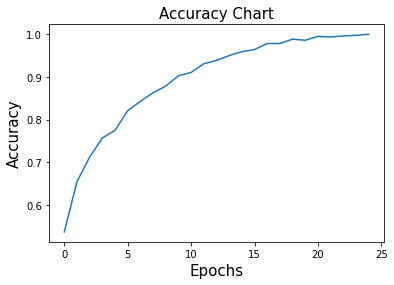

In [83]:
plt.plot(history['accuracy'])
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy Chart', fontsize=15)
plt.show()

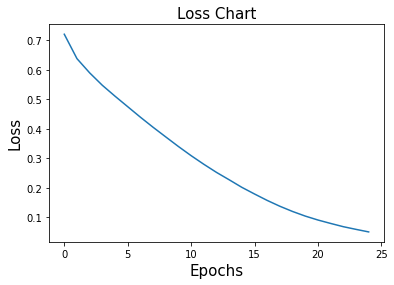

In [84]:
plt.plot(history['loss'])
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Loss Chart', fontsize=15)
plt.show()

In [39]:
conn = sqlite3.connect('../res/data/tables.sql')
cursor = conn.cursor()

In [40]:
cursor.execute('''
SELECT profile.id, school, gender, age, "home address", "parents cohabitation", 
"moms education", "dads education", "moms job", "dads job", "choice reason", 
guardian, "travel time", "nursery education", "internet access", "higher education",
"significant other", "household size", "family relationship", "free time",
"social activities", "study time", "first periods grade", "second periods grade",
"third periods grade", failures, absences, health, "weekday drinking",
"weekend drinking", "heavy drinking"
FROM profile
JOIN activities
ON profile.id = activities.id
''')

rows = cursor.fetchall()
description = cursor.description
conn.close()

In [41]:
data_df = pd.DataFrame(data=rows, columns=map(lambda x: x[0], description))
data_df = data_df.set_index('id')
data_df[:3]

,school,gender,age,home address,parents cohabitation,moms education,dads education,moms job,dads job,choice reason,...,study time,first periods grade,second periods grade,third periods grade,failures,absences,health,weekday drinking,weekend drinking,heavy drinking
id,,,,,,,,,,,,,,,,,,,,,
1,GP,F,18,U,A,4,4,at_home,teacher,course,...,2,fail,fail,fail,0,6,3,1,1,no
2,GP,F,17,U,T,1,1,at_home,other,course,...,2,fail,fail,fail,0,4,3,1,1,no
3,GP,F,15,U,T,1,1,at_home,other,other,...,2,fail,fail,pass,3,10,3,2,3,yes


## Charts

In [42]:
import seaborn as sns

Text(0.5, 1.0, 'Average Weekday Drinking Vs Gender')

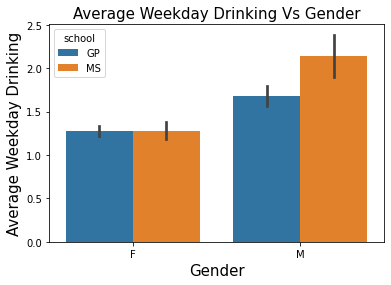

In [43]:
p = sns.barplot(x='gender', y='weekday drinking', hue='school', data=data_df)
p.set_xlabel('Gender', fontsize=15)
p.set_ylabel('Average Weekday Drinking', fontsize=15)
p.set_title('Average Weekday Drinking Vs Gender', fontsize=15)

Text(0.5, 1.0, 'Average Weekend Drinking Vs Gender')

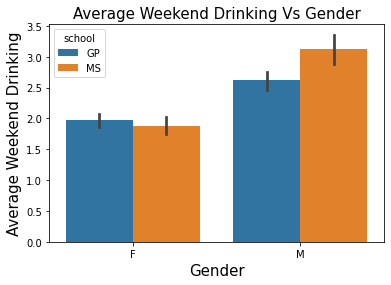

In [44]:
p = sns.barplot(x='gender', y='weekend drinking', hue='school', data=data_df)
p.set_xlabel('Gender', fontsize=15)
p.set_ylabel('Average Weekend Drinking', fontsize=15)
p.set_title('Average Weekend Drinking Vs Gender', fontsize=15)

Text(0.5, 1.0, 'Average Weekday Drinking Vs Significant Other')

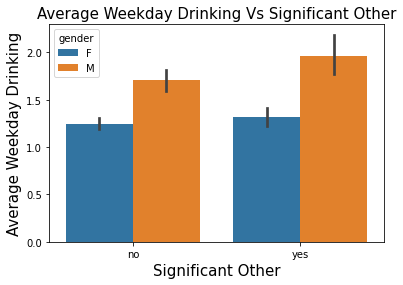

In [45]:
p = sns.barplot(x='significant other', y='weekday drinking', hue='gender', data=data_df)
p.set_xlabel('Significant Other', fontsize=15)
p.set_ylabel('Average Weekday Drinking', fontsize=15)
p.set_title('Average Weekday Drinking Vs Significant Other', fontsize=15)

Text(0.5, 1.0, 'Average Weekend Drinking Vs Significant Other')

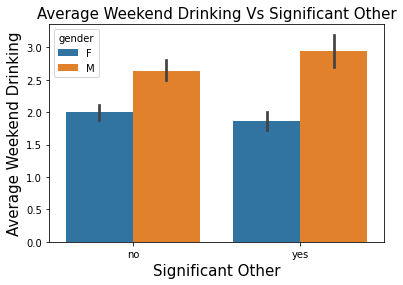

In [46]:
p = sns.barplot(x='significant other', y='weekend drinking', hue='gender', data=data_df)
p.set_xlabel('Significant Other', fontsize=15)
p.set_ylabel('Average Weekend Drinking', fontsize=15)
p.set_title('Average Weekend Drinking Vs Significant Other', fontsize=15)

Text(0.5, 1.0, 'Count of Significant Other Vs Significant Other')

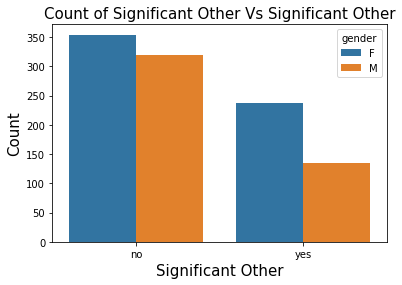

In [47]:
p = sns.countplot(x='significant other',hue='gender', data=data_df)
p.set_xlabel('Significant Other', fontsize=15)
p.set_ylabel('Count', fontsize=15)
p.set_title('Count of Significant Other Vs Significant Other', fontsize=15)

Text(0.5, 1.0, 'Absences Vs Weekday Drinking')

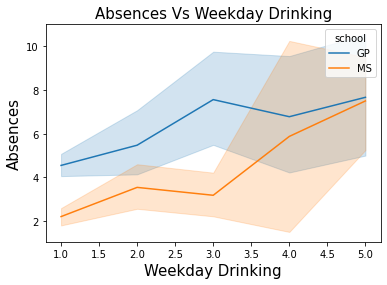

In [74]:
p = sns.lineplot(x='weekday drinking', y='absences', hue='school', data=data_df)
p.set_ylabel('Absences', fontsize=15)
p.set_xlabel('Weekday Drinking', fontsize=15)
p.set_title('Absences Vs Weekday Drinking', fontsize=15)

Text(0.5, 1.0, 'Absences Vs Weekend Drinking')

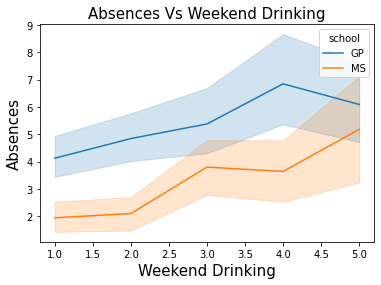

In [75]:
p = sns.lineplot(x='weekend drinking', y='absences', hue='school', data=data_df)
p.set_ylabel('Absences', fontsize=15)
p.set_xlabel('Weekend Drinking', fontsize=15)
p.set_title('Absences Vs Weekend Drinking', fontsize=15)